# Gene co-localization analysis

In this section, we extract latent representations for each gene within individual cells and perform gene co-localization analysis.

This analysis is used to assess whether SVC learns semantically meaningful and cell-specific gene representations.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('/net/mulan/home/huiwann/spatial/SVC/')
import tifffile
from model.train import *
from model.utils import *
import torch 
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import pandas as pd
from scipy.stats import wilcoxon

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = '/net/mulan/home/huiwann/spatial/SVC/' 
dataset = 'data/seqfish' 
device = 'cuda:1'

In [3]:
train_seqfish = np.load(f"{data_path}{dataset}/train_seqfish.npz") 
train_image = train_seqfish["data_ori"]
train_cell_morphology = train_seqfish["cell_morphology"]
train_nuclear_morphology = train_seqfish["nuclear_morphology"]
train_data_location = train_seqfish["location"]
train_cell_cycle_label = train_seqfish["identity_label"]
train_cell_cycle = train_seqfish["identity"]

train_dataset = SVC_Dataset(
    data_ori=train_image,
    location=train_data_location,
    cell_morphology_vec=train_cell_morphology,
    nuclear_morphology_vec=train_nuclear_morphology,
    identity_vec=train_cell_cycle_label,
)
print("number of training cells:", len(train_dataset),', number of genes:', train_image.shape[1])
cell_median_train = np.median(train_image.sum((1,2,3)))

read_dir =f'{data_path}{dataset}/gene2vec_weight_seqfish.npy'
gene_names = np.loadtxt(f'{data_path}{dataset}/gene_names.txt', dtype=str).tolist()
gene2vec_weight = torch.from_numpy(np.load(read_dir)).float() ##n_gene * 200 print("shape of gene2vec_weight", gene2vec_weight.shape)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = False, num_workers = 4)

number of training cells: 157 , number of genes: 1000


**load the trained model and extract latent representations**

In [4]:
ckpt_dir = "/net/mulan/home/huiwann/spatial/SVC/checkpoints/"
ckpt = torch.load(ckpt_dir +'SVC_seqfish.pth', map_location=device)

new_ckpt = {k.replace('module.', ''): v for k, v in ckpt['model_state_dict'].items()}

model = SVC(
    gene2vec_weight = gene2vec_weight,
    cell_identity_dim = train_cell_cycle_label.shape[1],
).to(device)

model_dict = model.state_dict()
for key in model_dict:
    model_dict[key] = new_ckpt[key]
model.load_state_dict(model_dict)
latent_np = extract_latent_embeddings(
    model=model,
    loader=train_loader,
    device=device
)

# np.save(f"{data_path}/output/seqfish/embeddings_train.npy", latent_np)

**gene co-localization analysis for 49 well-annotated genes**

In [5]:
# seqfish+ genes in extended data fig 3
protrusionList = ['Cyb5r3', 'Sh3pxd2a', 'Ddr2', 'Kif1c', 'Kctd10', 
                    'Dynll2', 'Arhgap11a', 'Dync1li2', 'Palld', 'Naa50']

nuclearList = ['Col1a1', 'Fn1', 'Fbln2', 'Col6a2', 'Bgn',  
                 'Nid1', 'Lox', 'P4hb', 'Aebp1', 'Emp1',
                 'Col5a1', 'Sdc4', 'Postn', 'Col3a1', 'Pdia6',
                 'Col5a2', 'Itgb1', 'Calu', 'Pdia3']
                 
cytoplasmList = ['Ddb1', 'Myh9', 'Actn1', 'Tagln2', 'Kpnb1',
                   'Hnrnpf', 'Ppp1ca', 'Hnrnpl', 'Pcbp1', 'Tagln', 
                   'Fscn1', 'Psat1', 'Cald1', 'Snd1', 'Uba1',
                   'Hnrnpm', 'Cap1', 'Ssrp1', 'Ugdh', 'Caprin1']

nuclearSub1List = ['Thbs1', 'Serpine1', 'Ptx3', 'Tnc']
nuclearSub2List = ['Flna', 'Flnb', 'Plec', 'Flnc', 'Iqgap1']
nuclearSub3List = ['Numa1', 'Gorasp2']
print(len(nuclearList),len(cytoplasmList),len(protrusionList))

19 20 10


**calculate gene colocalization score based on pairwise distances of each gene pair within cells**

In [6]:
gene_interested = [gene for gene in cytoplasmList + nuclearList + protrusionList] 
train_count_sum = train_image.sum(axis=(2,3))

gene_colocal_score = cal_gene_colocal_score(latent_np, gene_names, train_count_sum, gene_interested)

  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:01<00:00, 147.50it/s]


A heatmap is used to visualize the gene co-localization matrix inferred by SVC, revealing three distinct spatial localization clusters among the 49 genes.

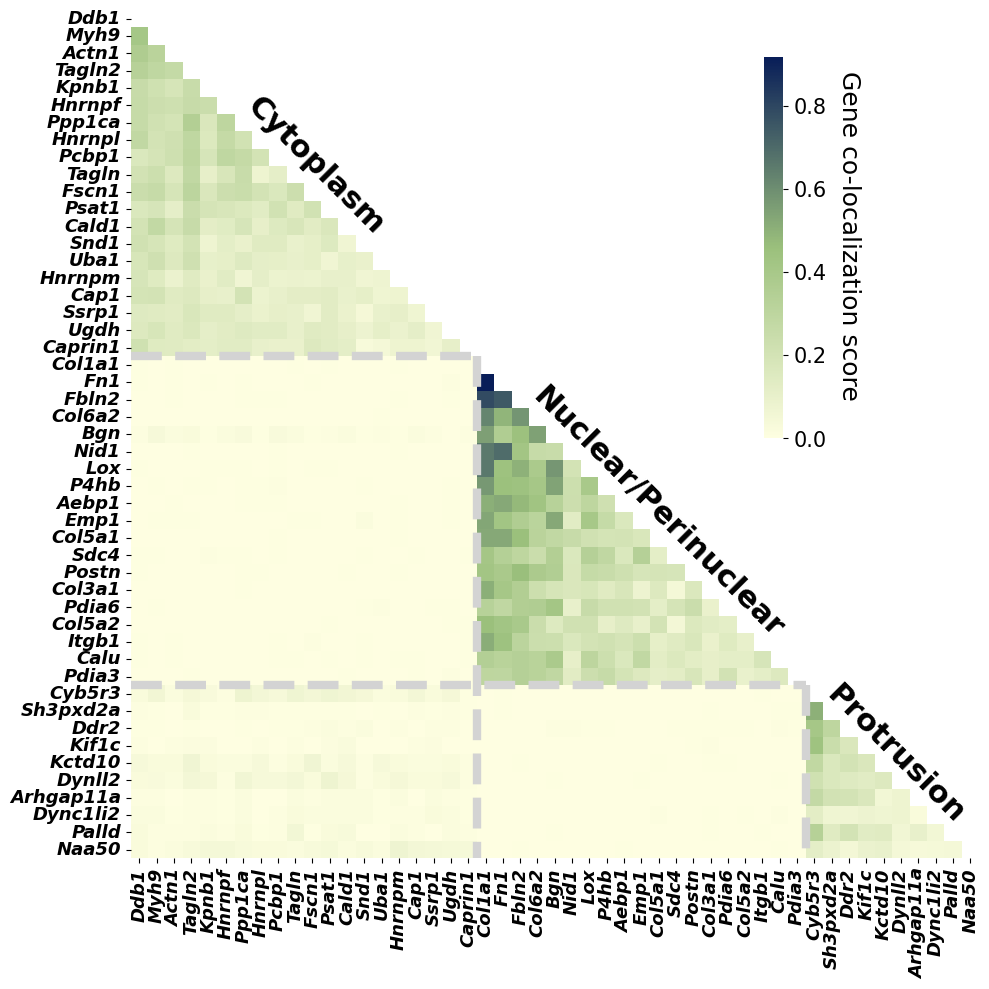

In [7]:
custom_cmap = create_color_cmap('#FEFEE1','#9bc07c','#081D58', name='white_to_red')

fig, ax = plt.subplots(figsize=(15, 10))

mask = np.triu(np.ones_like(gene_colocal_score, dtype=bool))
gene_interested_capitalized = [gene for gene in gene_interested]
heatmap = sns.heatmap(gene_colocal_score, cmap=custom_cmap,xticklabels=gene_interested_capitalized, yticklabels=gene_interested_capitalized,mask=mask, cbar_kws={'shrink': 0.45,'pad':-0.05,'anchor':(-0.7,0.9),"location":"right"}, # 调整颜色条大小 mask=mask,#
                   square=True) 
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontweight='bold',fontsize=13,fontstyle='italic')
heatmap.set_yticklabels(heatmap.get_xticklabels(), fontweight='bold',fontsize=13,fontstyle='italic')

cbar = heatmap.collections[0].colorbar
cbar.ax.set_position([1, 0.1, 0.9, 0.2])

cbar.ax.tick_params(labelsize=15)
cbar.set_label('Gene co-localization score', rotation=270, fontsize=18,loc='top',labelpad=25)##,fontweight='bold' proportion of cells in which the gene pair is considered as the 10 nearest neighbors
cbar_ax = cbar.ax
text_obj = cbar_ax.get_yaxis().get_label()

text_obj.set_position((-0.3, 0.1))
ax.plot([0, 20], [20, 20], color='lightgray', linestyle='--',linewidth=6)
ax.plot([0, 39], [39, 39], color='lightgray', linestyle='--',linewidth=6)
ax.plot([20, 20], [20, 49], color='lightgray', linestyle='--',linewidth=6)
ax.plot([39, 39], [39, 49], color='lightgray', linestyle='--',linewidth=6)

y_bottom=0
ax.text(15, y_bottom+9, 'Cytoplasm', va='center', ha='right', color='black', fontsize=22, fontweight='bold',rotation=315)
ax.text(38, y_bottom+29, 'Nuclear/Perinuclear', va='center', ha='right', color='black', fontsize=22, fontweight='bold',rotation=315)
ax.text(48.5, y_bottom+43, 'Protrusion', va='center', ha='right', color='black', fontsize=22, fontweight='bold',rotation=315)

plt.tight_layout()
# fig.savefig(f"{data_path}output/seqfish/figures/gene_colocalization_49.png",
#             transparent=True,      
#             dpi=300,
#             bbox_inches="tight")  
plt.show()

Further visualizing observed transcript profiles within original cells for three representative co-localization gene pairs.

In [8]:
print("most co-localized gene with Ddb1:",gene_interested[gene_colocal_score[gene_interested.index('Ddb1'),:].argsort()[::-1][0]])
print("\n")
print("most co-localized gene with Col1a1:",gene_interested[gene_colocal_score[gene_interested.index('Col1a1'),:].argsort()[::-1][0]])
print("\n")
print("most co-localized gene with Cyb5r3:",gene_interested[gene_colocal_score[gene_interested.index('Cyb5r3'),:].argsort()[::-1][0]])

most co-localized gene with Ddb1: Myh9


most co-localized gene with Col1a1: Fn1


most co-localized gene with Cyb5r3: Sh3pxd2a


In [9]:
seqfish_data = pd.read_pickle(f"{data_path}{dataset}/seqfish_data_dict.pkl")['data_df']
print(seqfish_data.head())
df_cell_contour = pd.read_pickle(f"{data_path}{dataset}/cell_mask_contour_preprocessed.pkl")
print(df_cell_contour.head())
df_nuclear_contour = pd.read_pickle(f"{data_path}{dataset}/nuclear_mask_contour_preprocessed.pkl")
print(df_nuclear_contour.head())

             x           y           gene cell nucleus batch  umi  centerX  \
0  1217.437557  557.583252  4933401b06rik  5-0      -1     0    1     1003   
1  1096.190309  394.835294  4933401b06rik  5-0       5     0    1     1003   
2  1093.189494  572.832405  4933401b06rik  5-0      -1     0    1     1003   
3  1005.120220  297.196271  4933401b06rik  5-0      -1     0    1     1003   
4  1142.815026  378.376491  4933401b06rik  5-0      -1     0    1     1003   

   centerY        type  sc_total  
0      425  fibroblast     32224  
1      425  fibroblast     32224  
2      425  fibroblast     32224  
3      425  fibroblast     32224  
4      425  fibroblast     32224  
  cell    x    y  centerX  centerY  direction_vec  distance_to_center
0  0-0  521  496     1079      724         -158.0          602.783543
1  0-0  519  496     1079      724         -158.0          604.635427
2  0-0  517  494     1079      724         -157.5          607.242950
3  0-0  515  494     1079      724       

In [10]:
batch='0'
preserve_idx_seqfish_data =[]
for i in seqfish_data.cell:
    if i.split('-')[1] == batch:
        preserve_idx_seqfish_data.append(True)
    else:
        preserve_idx_seqfish_data.append(False)
        
preserve_idx_seqfish_data = np.array(preserve_idx_seqfish_data)

preserve_idx_cell_mask_contour =[]
for i in df_cell_contour.cell:
    if i.split('-')[1] == batch:
        preserve_idx_cell_mask_contour.append(True)
    else:
        preserve_idx_cell_mask_contour.append(False)
        
preserve_idx_cell_mask_contour = np.array(preserve_idx_cell_mask_contour)

preserve_idx_nuclear_mask_contour =[]
for i in df_nuclear_contour.cell:
    if i.split('-')[1] == batch:
        preserve_idx_nuclear_mask_contour.append(True)
    else:
        preserve_idx_nuclear_mask_contour.append(False)
        
preserve_idx_nuclear_mask_contour = np.array(preserve_idx_nuclear_mask_contour)

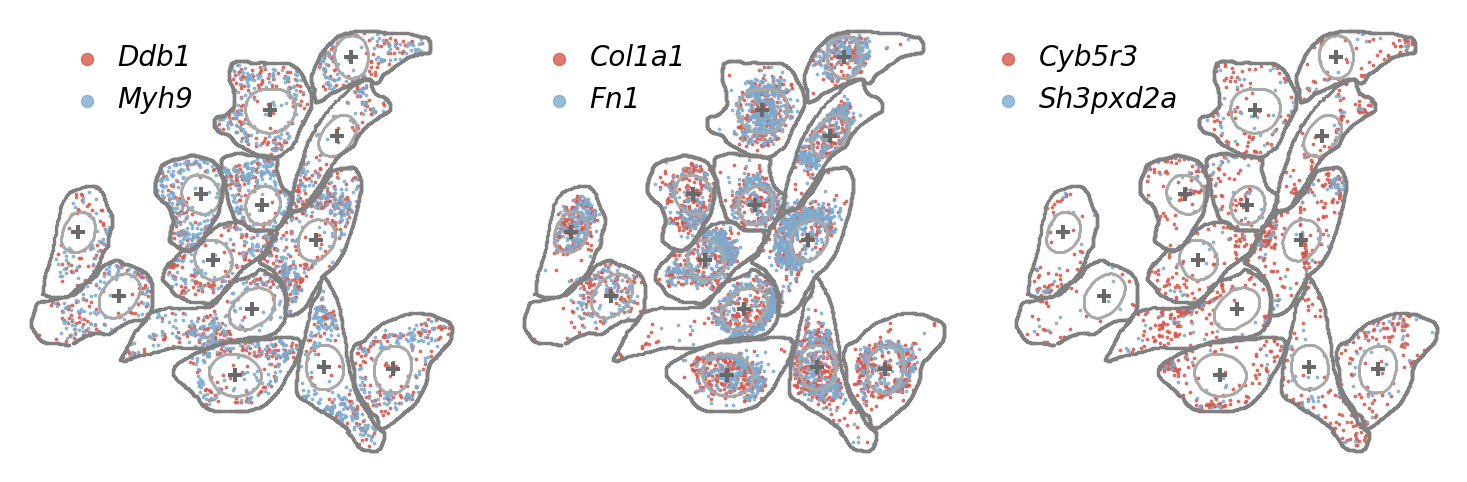

In [11]:
seqfish_data_i = seqfish_data[preserve_idx_seqfish_data]
cell_mask_contour_i= df_cell_contour[preserve_idx_cell_mask_contour]
nuclear_mask_contour_i = df_nuclear_contour[preserve_idx_nuclear_mask_contour]

fig, ax = plt.subplots(1, 3, figsize=(19, 6), gridspec_kw={'hspace': 0., 'wspace': 0.01})

gene_pair0 = ['Ddb1', 'Myh9']
seqfish_data_i_gene1 = seqfish_data_i[seqfish_data_i.gene == gene_pair0[0]]
seqfish_data_i_gene2 = seqfish_data_i[seqfish_data_i.gene == gene_pair0[1]]

gene_pair1 = ['Col1a1', 'Fn1']
seqfish_data_i_gene3 = seqfish_data_i[seqfish_data_i.gene == gene_pair1[0]]
seqfish_data_i_gene4 = seqfish_data_i[seqfish_data_i.gene == gene_pair1[1]]

gene_pair2 =['Cyb5r3', 'Sh3pxd2a']
seqfish_data_i_gene5 = seqfish_data_i[seqfish_data_i.gene == gene_pair2[0]]
seqfish_data_i_gene6 = seqfish_data_i[seqfish_data_i.gene == gene_pair2[1]]

ax[0].scatter(seqfish_data_i_gene1['x'], seqfish_data_i_gene1['y'], label=gene_pair0[0], alpha=0.8, s=3,color='#d6594c')
ax[0].scatter(seqfish_data_i_gene2['x'], seqfish_data_i_gene2['y'], label=gene_pair0[1], alpha=0.8, s=3,color='#7dabcf')
ax[1].scatter(seqfish_data_i_gene3['x'], seqfish_data_i_gene3['y'], label=gene_pair1[0], alpha=0.8, s=3,color='#d6594c')
ax[1].scatter(seqfish_data_i_gene4['x'], seqfish_data_i_gene4['y'], label=gene_pair1[1], alpha=0.8, s=3,color='#7dabcf')
ax[2].scatter(seqfish_data_i_gene5['x'], seqfish_data_i_gene5['y'], label=gene_pair2[0], alpha=0.8, s=3,color='#d6594c')
ax[2].scatter(seqfish_data_i_gene6['x'], seqfish_data_i_gene6['y'], label=gene_pair2[1], alpha=0.8, s=3,color='#7dabcf')

for i in range(3):
    ax[i].axis('off')
    ax[i].scatter(nuclear_mask_contour_i['x'], nuclear_mask_contour_i['y'], alpha=0.6, s=0.5,color='darkgrey')

    ax[i].scatter(cell_mask_contour_i['x'], cell_mask_contour_i['y'], color='grey', s=2)
    ax[i].scatter(cell_mask_contour_i['centerX'], cell_mask_contour_i['centerY'], marker='+', color='dimgray', s=100)
    leg = ax[i].legend(fontsize=20,markerscale=5,bbox_to_anchor=(0.45, 0.72),frameon=False,handletextpad=0.1)
    for t in leg.get_texts():     
        t.set_fontstyle('italic')
    ax[i].set_aspect('equal')

# plt.savefig(f'{data_path}/output/seqfish/figures/gene_colocalization_examples_batch{batch}.png', dpi=300, bbox_inches='tight',transparent=True)
plt.show()